In [43]:
import pandas as pd
from ai_cdss.constants import *
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.gridspec import GridSpec
import seaborn as sns
import numpy as np
from scipy.signal import savgol_filter


In [7]:
data = pd.read_parquet('data/nest_data.parquet')

In [8]:
data.columns

Index(['PATIENT_ID', 'HOSPITAL_ID', 'PARETIC_SIDE', 'UPPER_EXTREMITY_TO_TRAIN',
       'HAND_RAISING_CAPACITY', 'COGNITIVE_FUNCTION_LEVEL',
       'HAS_HEMINEGLIGENCE', 'GENDER', 'SKIN_COLOR', 'AGE', 'VIDEOGAME_EXP',
       'COMPUTER_EXP', 'COMMENTS', 'PTN_HEIGHT_CM', 'ARM_SIZE_CM',
       'PRESCRIPTION_ID', 'SESSION_ID', 'PROTOCOL_ID',
       'PRESCRIPTION_STARTING_DATE', 'PRESCRIPTION_ENDING_DATE',
       'SESSION_DATE', 'STARTING_HOUR', 'STARTING_TIME_CATEGORY', 'STATUS',
       'PROTOCOL_TYPE', 'AR_MODE', 'WEEKDAY_INDEX', 'REAL_SESSION_DURATION',
       'PRESCRIBED_SESSION_DURATION', 'SESSION_DURATION', 'ADHERENCE',
       'TOTAL_SUCCESS', 'TOTAL_ERRORS', 'SCORE', 'SECONDS_FROM_START',
       'DM_KEY', 'DM_VALUE', 'PE_KEY', 'PE_VALUE', 'PPF', 'CONTRIB'],
      dtype='object')

In [25]:
def compute_metrics(
        df,
        alpha=0.5,
        window_size=7,
        scaling_factor = 2,
        min_window = 5,
        max_window = 21,
        polyorder=2,
        deriv=1,
    ):
    df = df.reset_index(drop=True)  # clean index for plotting
    
    # Compute smoothed dm
    df['DM_VALUE_EWMA'] = df['DM_VALUE'].ewm(alpha=alpha, adjust=True).mean()
    # Compute delta DM
    df['DELTA_DM'] = df['DM_VALUE'].diff().fillna(0)
    # Compute EWMA of DM
    df['DELTA_DM_EWMA'] = df['DELTA_DM'].ewm(alpha=alpha, adjust=True).mean()
    # Compute raw DM
    df['DELTA_DM_RAW'] = df['DM_VALUE'].diff().fillna(0)

    # Compute Savitzky-Golay filter of DM
    if window_size:
        window_length = window_size
    else:
        window_length = int(np.clip(1 / alpha * scaling_factor, min_window, max_window))
        if window_length % 2 == 0:
            window_length += 1  # ensure odd

    try:
        df['SG_DM'] = savgol_filter(df['DM_VALUE'], window_length=window_length, polyorder=polyorder, deriv=deriv)
    except ValueError:
        df['SG_DM'] = df['DM_VALUE']  # fallback: raw DM value

    # Compute score
    a = 1
    b = 1
    c = 1
    df['CDSS_SCORE'] = a * df['PPF'] + b * df['SG_DM'] + c * df['ADHERENCE']

    return df

In [ ]:
def plot_metrics(
        df, 
        show="both",  # Options: "sg", "ewma", "both"
        filename=None,
    ):
    
    # Plotting
    fig = plt.figure(figsize=(12, 8))
    spec = gridspec.GridSpec(5, 1, height_ratios=[2, 1, 3, 3, 1])  # 3/4 for DM, 1/4 for PE

    # --- CDSS: Score
    ax_cdss = fig.add_subplot(spec[0])
    sns.lineplot(data=df, x=df.index, y='CDSS_SCORE', color='blue', alpha=0.5)
    ax_cdss.set_xlabel('')
    ax_cdss.set_ylabel('CDSS Score')
    ax_cdss.tick_params(labelbottom=False)
    ax_cdss.spines['right'].set_visible(False)

    # --- Adherence plot
    ax_ad = fig.add_subplot(spec[1], sharex=ax_cdss)
    sns.lineplot(data=df, x=df.index, y='ADHERENCE', ax=ax_ad, color='blue')
    ax_ad.set_ylim(0, 1.09)
    ax_ad.set_xlabel('')
    ax_ad.set_ylabel('Adherence')
    ax_ad.tick_params(labelbottom=False)
    ax_ad.spines['right'].set_visible(False)
    # ax_ad.spines['bottom'].set_visible(False)
    
    # --- Delta DM
    ax_dm_delta = fig.add_subplot(spec[2], sharex=ax_cdss)
    ax_dm_delta.spines['top'].set_visible(False)
    ax_dm_delta.spines['right'].set_visible(False)
    ax_dm_delta.set_xlabel('')
    ax_dm_delta.set_ylabel('Delta DM')
    ax_dm_delta.set_ylim(-0.2, 0.2)
    ax_dm_delta.legend(loc='lower right')
    ax_dm_delta.tick_params(labelbottom=False)

    # Secondary axis: Delta DM
    # ax_dm_delta = ax_dm.twinx()
    # Conditional plotting
    if show in ["both", "ewma"]:
        sns.lineplot(data=df, x=df.index, y='DELTA_DM_EWMA', ax=ax_dm_delta, linewidth=1.5, color='orange', label='ΔDM EWMA')
    if show in ["both", "sg"]:
        sns.lineplot(data=df, x=df.index, y='SG_DM', ax=ax_dm_delta, linewidth=1.5, color='purple', label='ΔDM Savitzky')
    if show == "raw":
        sns.lineplot(data=df, x=df.index, y='DELTA_DM_RAW', ax=ax_dm_delta, linewidth=1.5, color='red', label='ΔDM Raw')

    # --- First plot: DM_VALUE ---
    ax_dm = fig.add_subplot(spec[3], sharex=ax_cdss)
    sns.lineplot(data=df, x=df.index, y='DM_VALUE', ax=ax_dm, alpha=0.8, color='black', linewidth=1)
    sns.lineplot(data=df, x=df.index, y='DM_VALUE_EWMA', ax=ax_dm, linewidth=2)

    # Session change markers
    if 'SESSION_ID' in df.columns:
        change_mask = df['SESSION_ID'].ne(df['SESSION_ID'].shift())
        change_points = df.index[change_mask]
        session_labels = df['SESSION_ID'][change_mask].astype(str).tolist()

        for cp, label in zip(change_points, session_labels):
            ax_dm.plot([cp, cp], [1.09 - (1.09 - 0) * 0.02, 1.09], color='red', linewidth=1.5)
            # ax_dm.text(cp, ymax + (ymax - ymin) * 0.03, f"S{label}", color='red',
            #            ha='center', va='bottom', fontsize=8, rotation=0)

    ax_dm.set_ylim(0, 1.09)
    # ax_dm.set_title(f'DM value — Patient {i[0]}, Protocol {i[1]}')
    ax_dm.set_xlabel('')
    ax_dm.set_ylabel('DM Value')
    ax_dm.grid(False)
    ax_dm.tick_params(labelbottom=False)
    ax_dm.spines['top'].set_visible(False)
    ax_dm.spines['right'].set_visible(False)


    # --- Second plot: PE_VALUE ---
    ax_pe = fig.add_subplot(spec[4], sharex=ax_dm)
    sns.lineplot(data=df, x=df.index, y='PE_VALUE', ax=ax_pe, color='green')
    ax_pe.axhline(y=0.7, color='darkgreen', linestyle='--', alpha=0.7)

    ax_pe.set_title('PE Value')
    ax_pe.set_xlabel('Timepoint')
    ax_pe.set_ylabel('PE Value')
    ax_pe.spines['top'].set_visible(False)
    ax_pe.spines['right'].set_visible(False)
    ax_pe.set_ylim(0, 1.09)
    

    # fig.suptitle(f'Patient {i[0]}, Protocol {i[1]}', fontsize=16)

    plt.tight_layout()

    if filename:
        plt.savefig(filename, dpi=300)
    else:
        plt.show()

    plt.close(fig)

## Metrics

### Example

In [2]:
patient_data = data[(data[PATIENT_ID] == 787) & (data[PROTOCOL_ID] == 201)]
plot_metrics(
    df=compute_metrics(
        patient_data, 
        alpha=0.05, 
        window_size=7
    ),
    show="ewma"
)

NameError: name 'data' is not defined

### Generate Figures

In [444]:
# Output directory
output_dir = "dms_nest_complete"
os.makedirs(output_dir, exist_ok=True)

custom_params = {"axes.spines.right": True, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

for idx, (i, group) in enumerate(data.groupby(by=BY_PP)):
    group = group.reset_index(drop=True)  # clean index for plotting

    # Compute metrics
    group = compute_metrics(
        group,
        alpha=0.5,
        window_size=7
    )

    # Save figure
    filename = f"patient_{i[0]}_protocol_{i[1]}.png"
    filepath = os.path.join(output_dir, filename)
    
    # Plot DM
    plot_metrics(
        group,
        show="sg",
        filename=filepath
    )

    print(f"✅ Saved: {filepath}")

# All figures saved
print(f"\n✅ All figures saved to {output_dir}/")


✅ Saved: dms_nest_complete/patient_775_protocol_206.png
✅ Saved: dms_nest_complete/patient_775_protocol_208.png
✅ Saved: dms_nest_complete/patient_775_protocol_214.png
✅ Saved: dms_nest_complete/patient_775_protocol_222.png
✅ Saved: dms_nest_complete/patient_775_protocol_224.png
✅ Saved: dms_nest_complete/patient_787_protocol_201.png
✅ Saved: dms_nest_complete/patient_787_protocol_211.png
✅ Saved: dms_nest_complete/patient_787_protocol_221.png
✅ Saved: dms_nest_complete/patient_787_protocol_223.png
✅ Saved: dms_nest_complete/patient_787_protocol_224.png
✅ Saved: dms_nest_complete/patient_788_protocol_201.png
✅ Saved: dms_nest_complete/patient_788_protocol_206.png
✅ Saved: dms_nest_complete/patient_788_protocol_208.png
✅ Saved: dms_nest_complete/patient_788_protocol_209.png
✅ Saved: dms_nest_complete/patient_788_protocol_211.png
✅ Saved: dms_nest_complete/patient_788_protocol_223.png
✅ Saved: dms_nest_complete/patient_1123_protocol_206.png
✅ Saved: dms_nest_complete/patient_1123_protoco

### Generate Report

In [279]:
import os
import pandas as pd

# Folder where your images are saved
input_dir = "dms_nest"

# Get all image filenames
image_files = [f for f in os.listdir(input_dir) if f.endswith(".png")]

# Parse patient IDs and protocol IDs from filenames
data = []
for filename in image_files:
    try:
        parts = filename.replace(".png", "").split("_")
        patient_id = int(parts[1])
        protocol_id = int(parts[3])
        data.append((protocol_id, patient_id, filename))
    except Exception as e:
        print(f"Skipping file {filename}: {e}")

# Create DataFrame
df = pd.DataFrame(data, columns=["PROTOCOL_ID", "PATIENT_ID", "FILENAME"])

# Get unique patients and protocols
patients = sorted(df["PATIENT_ID"].unique())
protocols = sorted(df["PROTOCOL_ID"].unique())

# Start HTML
html_content = """
<html>
<head>
<style>
body {
    margin: 0;
    padding: 0;
    font-family: Arial, sans-serif;
}
table {
    table-layout: fixed;
    border-collapse: collapse;
    width: auto;
    white-space: nowrap;
    border: 1px solid #ccc;
}
td, th {
    border: 1px solid #ccc;
    padding: 5px;
    text-align: center;
}
img {
    width: 300px;
    height: auto;
    display: block;
    margin: auto;
    border: 1px solid #ddd;
}
th {
    background-color: #f9f9f9;
}
</style>
</head>
<body>
<h2>Protocol × Patient Gallery</h2>
<table>
<tr>
    <th>Protocol \\ Patient</th>
"""

# Add header row (patients)
for patient_id in patients:
    html_content += f"<th>Patient {patient_id}</th>"
html_content += "</tr>\n"

# Add rows for protocols
for protocol_id in protocols:
    html_content += f"<tr><th>Protocol {protocol_id}</th>"
    for patient_id in patients:
        # Check if image exists
        match = df[(df["PROTOCOL_ID"] == protocol_id) & (df["PATIENT_ID"] == patient_id)]
        if not match.empty:
            filename = match["FILENAME"].values[0]
            html_content += f'<td><img src="{filename}"></td>'
        else:
            html_content += "<td></td>"  # Empty cell if no image
    html_content += "</tr>\n"

html_content += """
</table>
</body>
</html>
"""

# Save HTML file
output_html = os.path.join(input_dir, "nest_gallery.html")
with open(output_html, "w") as f:
    f.write(html_content)

print(f"✅ Gallery HTML created: {output_html}")


✅ Gallery HTML created: dms_nest/nest_gallery.html


## Score

In [362]:
scores = data.groupby([PATIENT_ID, PROTOCOL_ID]).apply(
    lambda x: 
        compute_metrics(
            x, 
            alpha=0.5, 
            window_size=7
        ),
    include_groups=False
).reset_index()

# Compute patient-level "Day Index"
scores['DAY_INDEX'] = scores.groupby('PATIENT_ID')['SESSION_DATE'].transform(
    lambda x: (x - x.min()).dt.days
)

In [ ]:
def plot_score(group, filename=None):    
    # Heatmap
    pivot = group.pivot_table(
        index='PROTOCOL_ID',
        columns='DAY_INDEX',
        values='CDSS_SCORE',
        aggfunc='last'
    ).astype(float)

    # Ensure all days in x-axis
    all_days = np.arange(group['DAY_INDEX'].min(), group['DAY_INDEX'].max() + 1)
    pivot = pivot.reindex(columns=all_days, fill_value=np.nan)
    pivot = pivot.ffill(axis=1).astype(float)

    # Prepare the figure
    fig = plt.figure(figsize=(12, 4))
    gs = GridSpec(2, 2, width_ratios=[22, 1], height_ratios=[1, 1], figure=fig)

    # Main plot axes
    ax_line = fig.add_subplot(gs[0, 0])
    ax_heatmap = fig.add_subplot(gs[1, 0], sharex=ax_line)

    # Colorbar axes
    cbar_ax = fig.add_subplot(gs[1, 1])

    # --- Line plot ---
    sns.lineplot(
        data=group,
        x='DAY_INDEX',
        y='CDSS_SCORE',
        hue='PROTOCOL_ID',
        marker='o',
        linewidth=2,
        palette='tab10',
        ax=ax_line
    )

    ax_line.set_ylabel("CDSS Score")
    ax_line.set_xlabel("")
    # ax_line.set_title(f"Patient {i} - CDSS Score by Protocol")
    ax_line.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax_line.label_outer()  # remove inner labels

    # --- Heatmap ---
    sns.heatmap(
        pivot,
        annot=False,
        fmt=".2f",
        cmap="YlOrRd",
        cbar_ax=cbar_ax,
        cbar_kws={'label': 'CDSS Score'},
        ax=ax_heatmap
    )

    ax_heatmap.set_xlabel("Day Index")
    ax_heatmap.set_ylabel("Protocol ID")
    ax_heatmap.label_outer()  # remove inner labels

    fig.suptitle(f"Patient {i} - CDSS Score by Protocol")
    plt.tight_layout()

    if filename:
        plt.savefig(filename, dpi=300)
    else:
        plt.show()
    
    plt.close(fig)

/tmp/ipykernel_3760584/4091409185.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(12, 4))


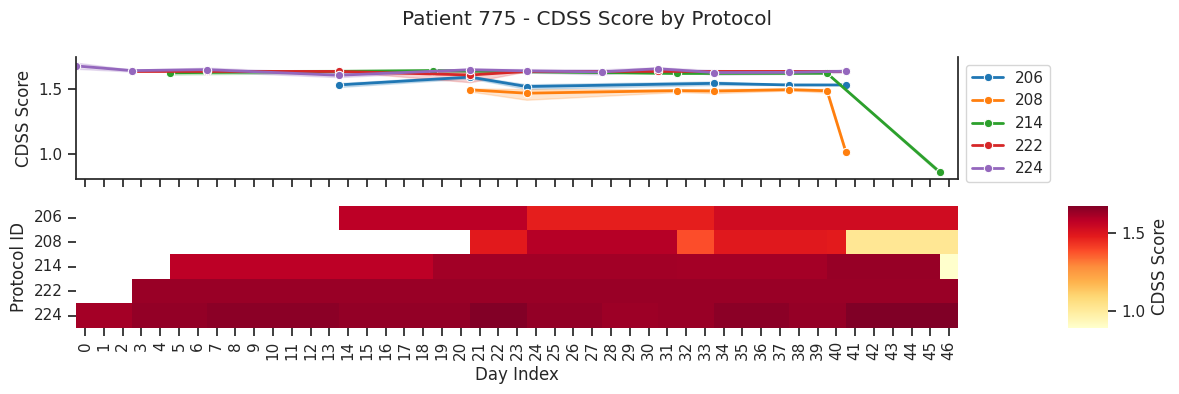

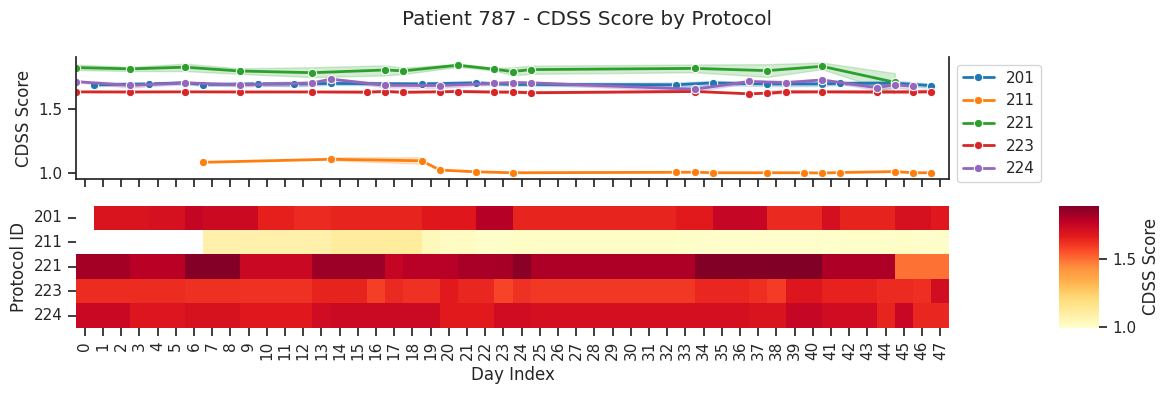

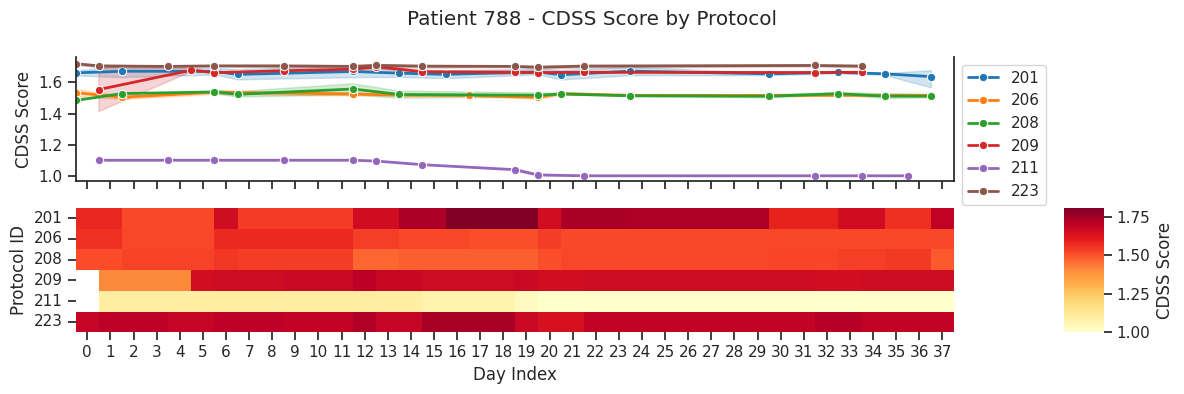

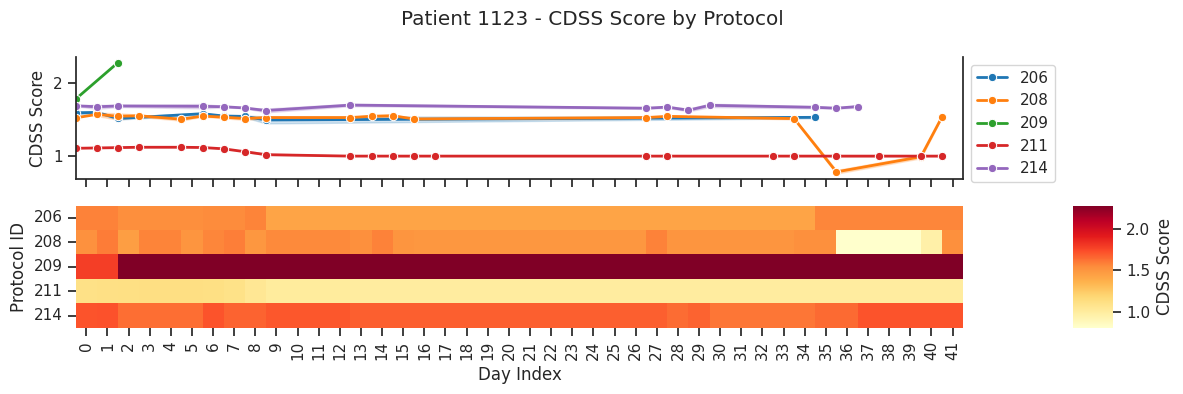

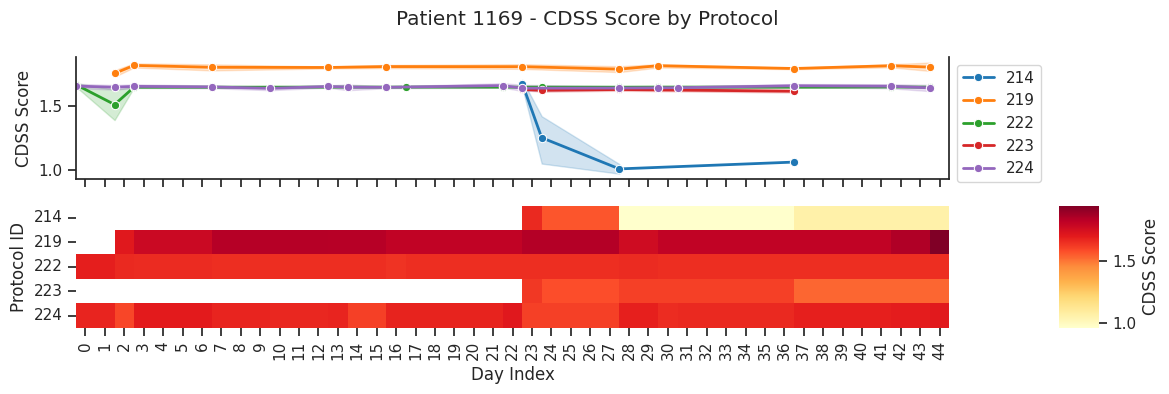

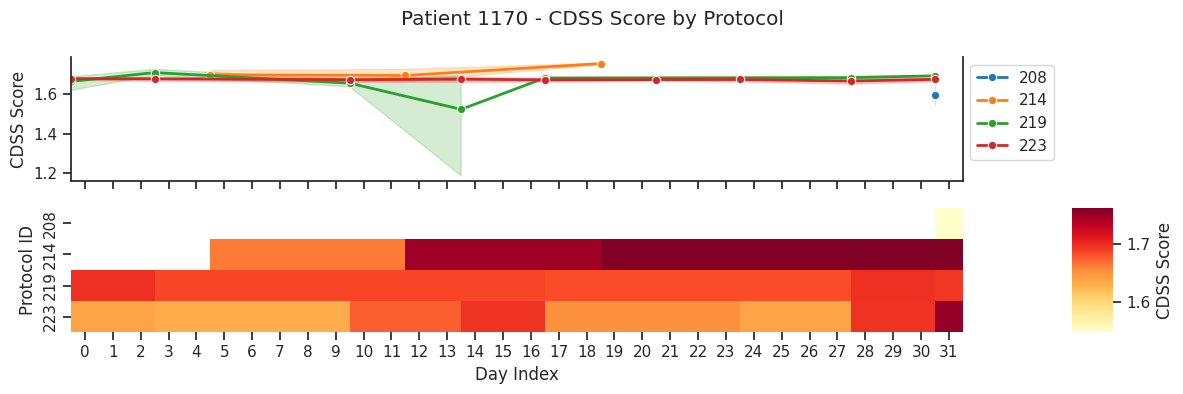

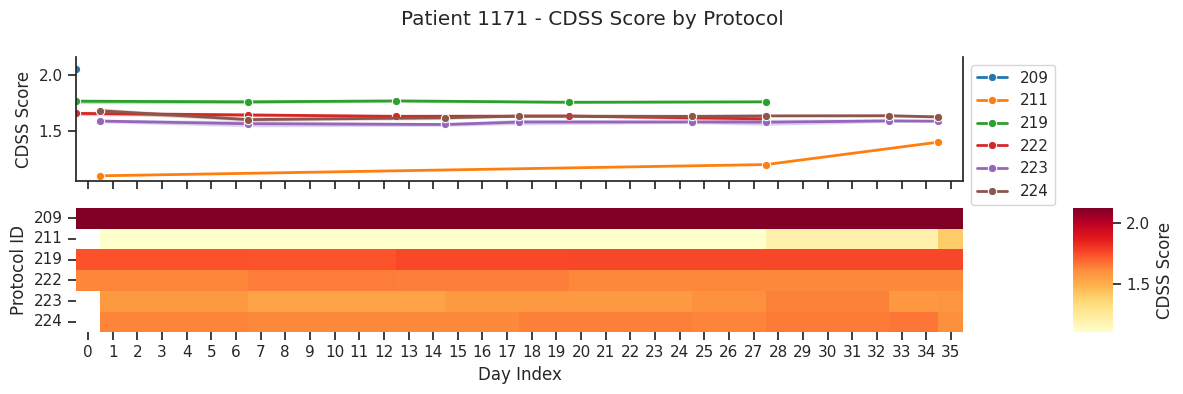

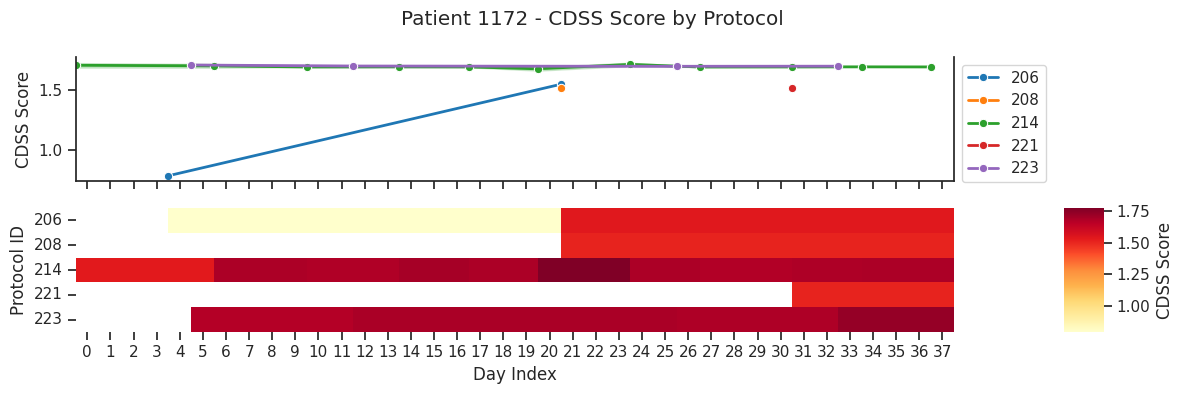

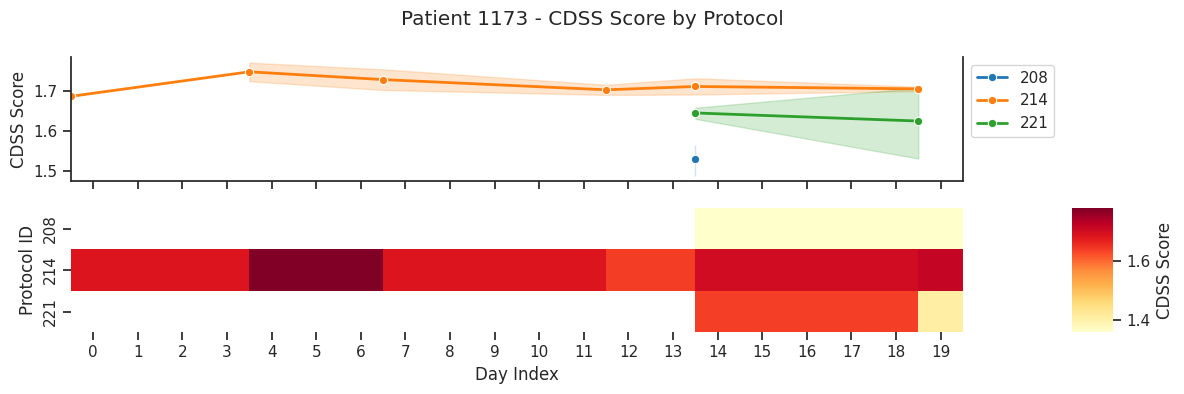

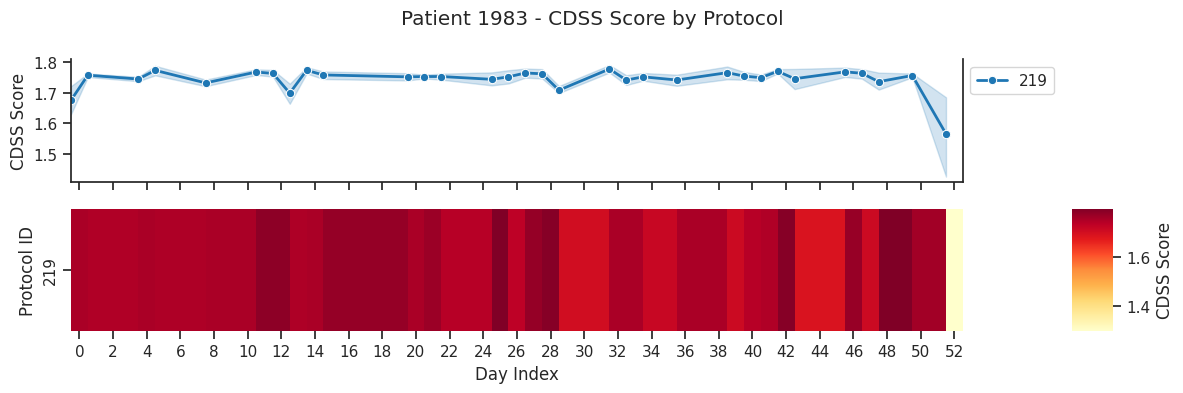

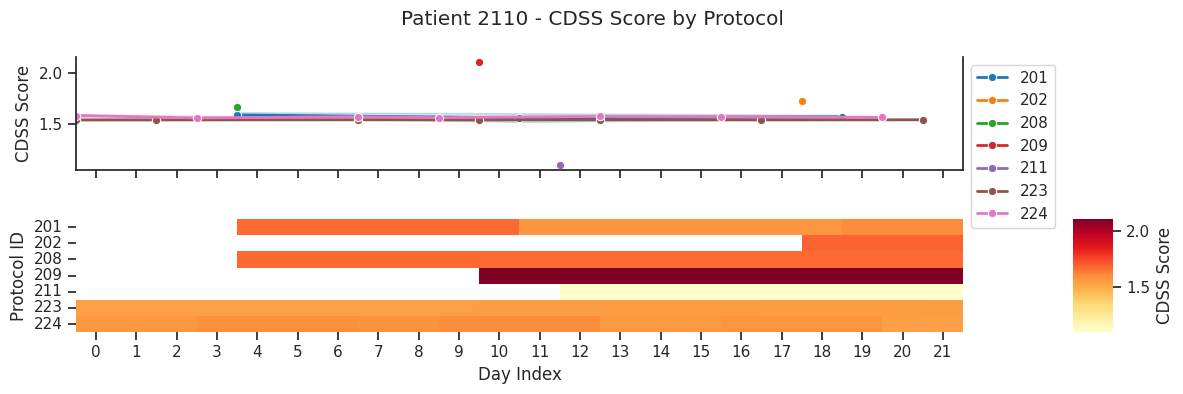

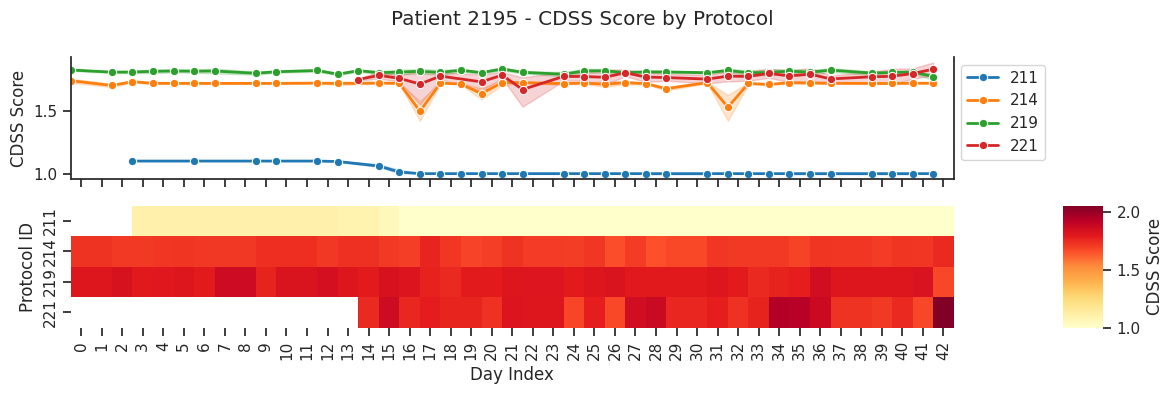

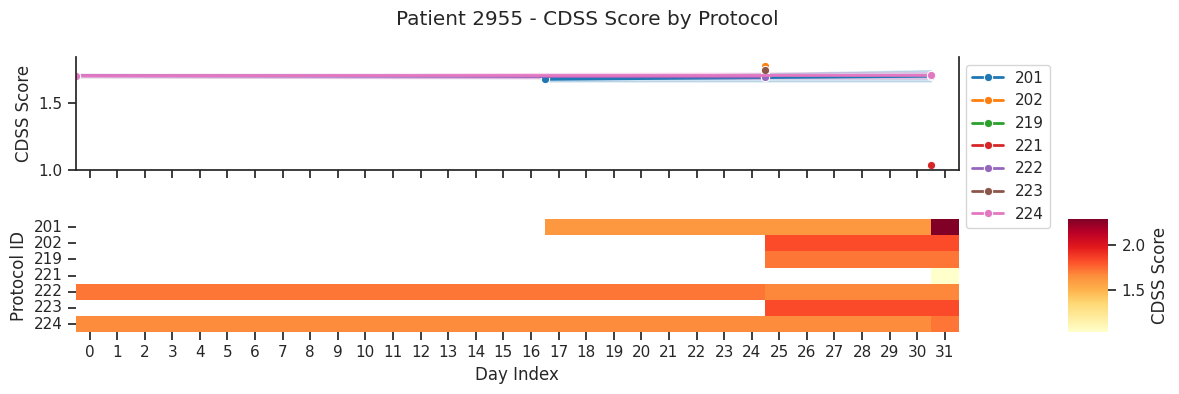

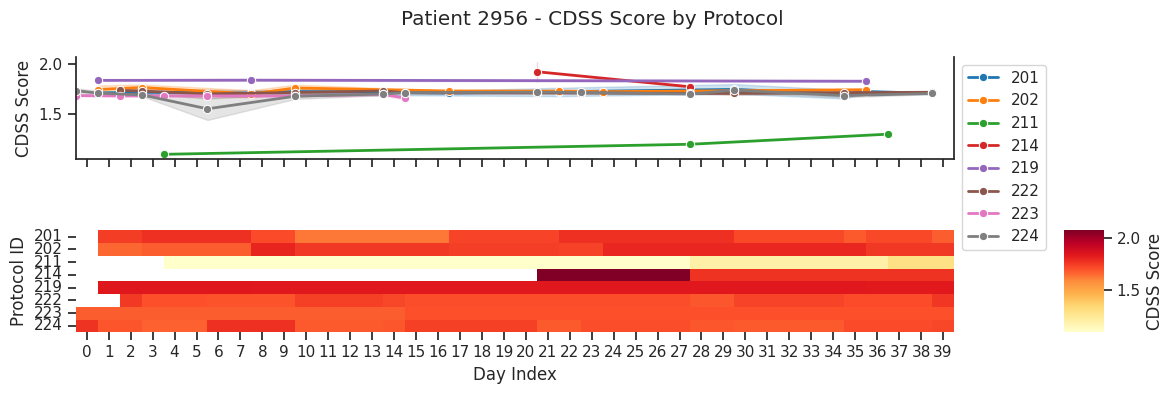

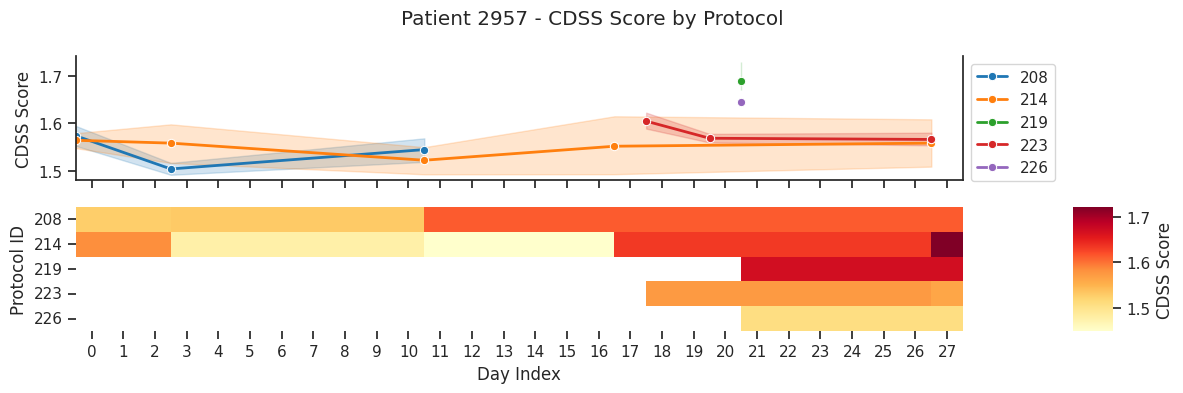

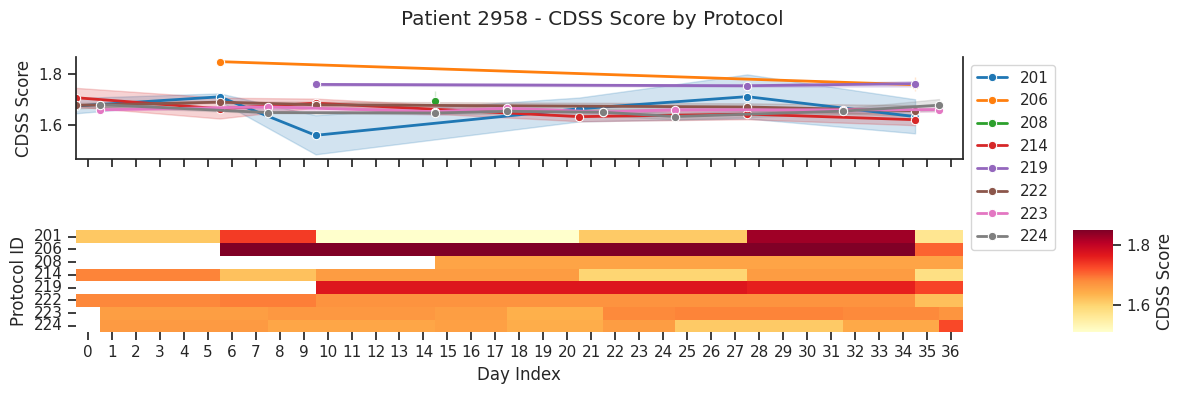

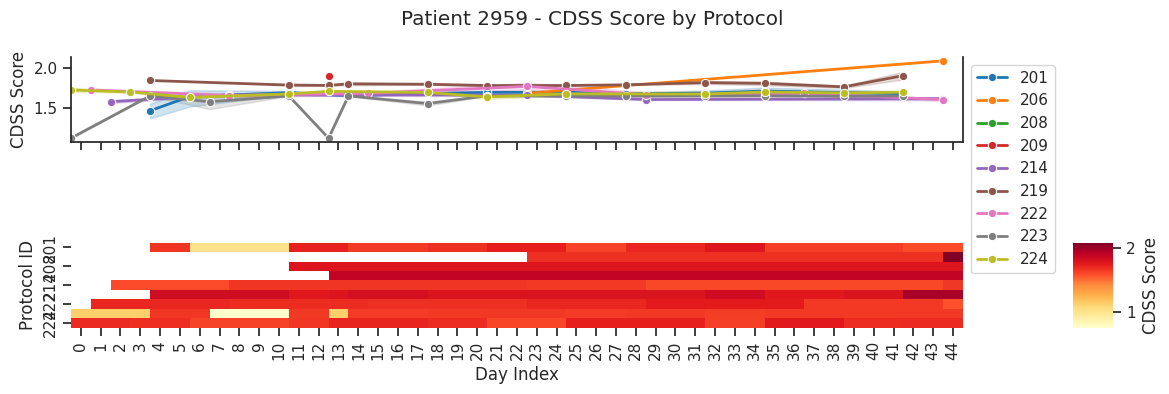

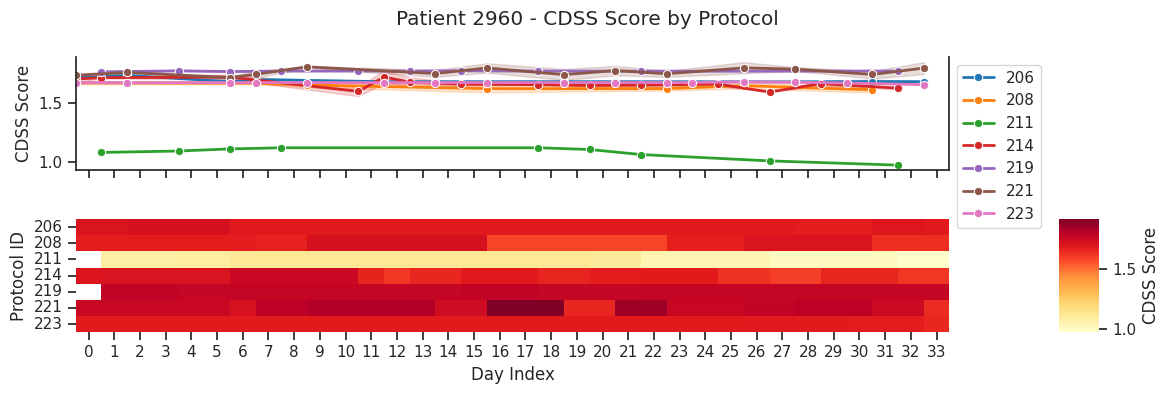

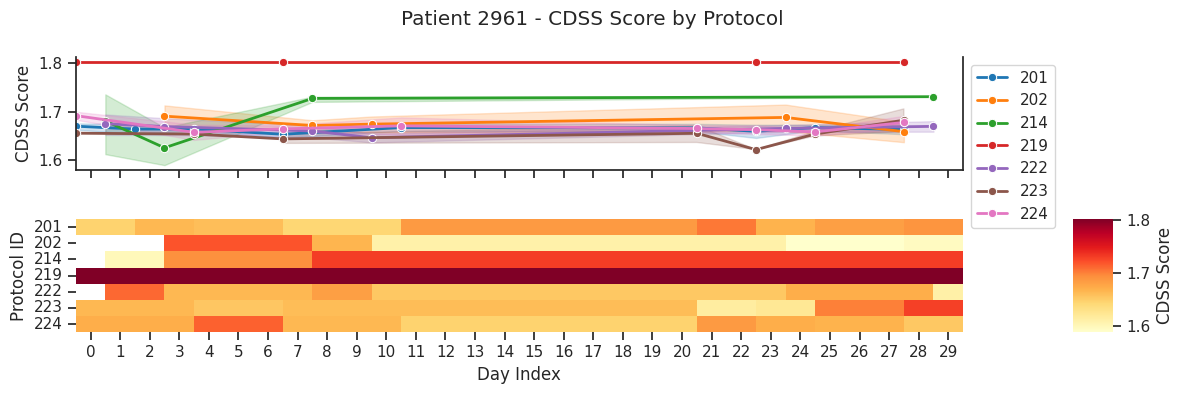

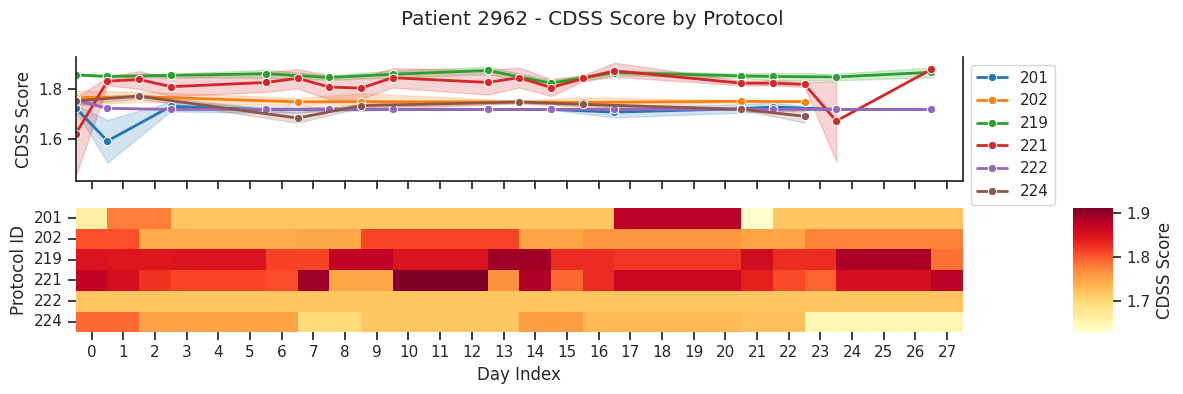

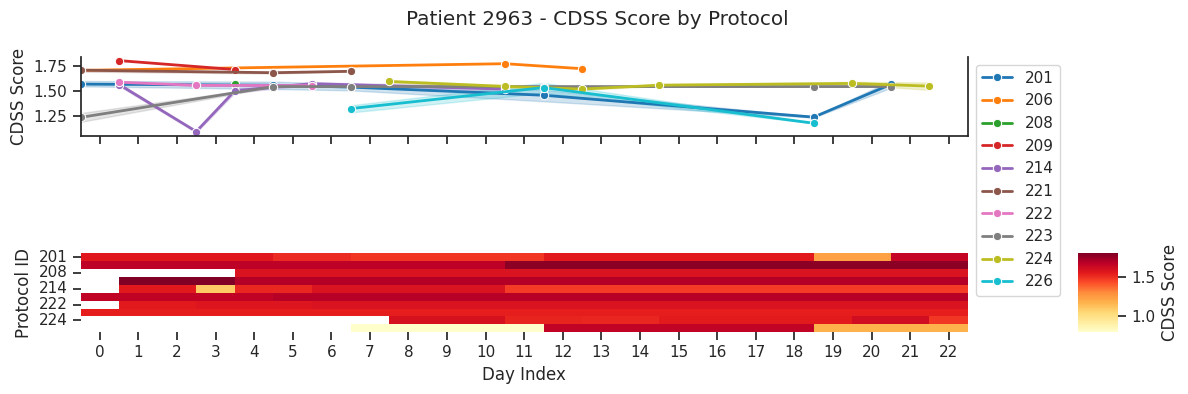

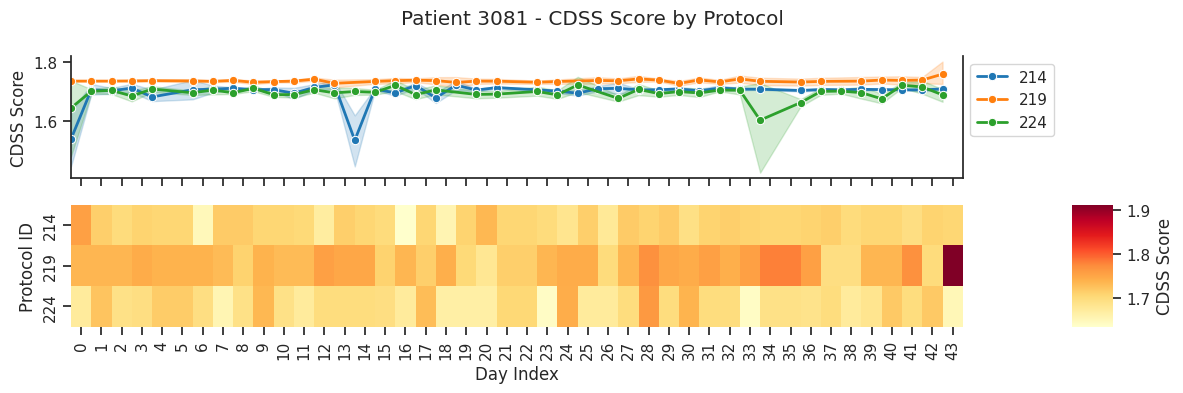

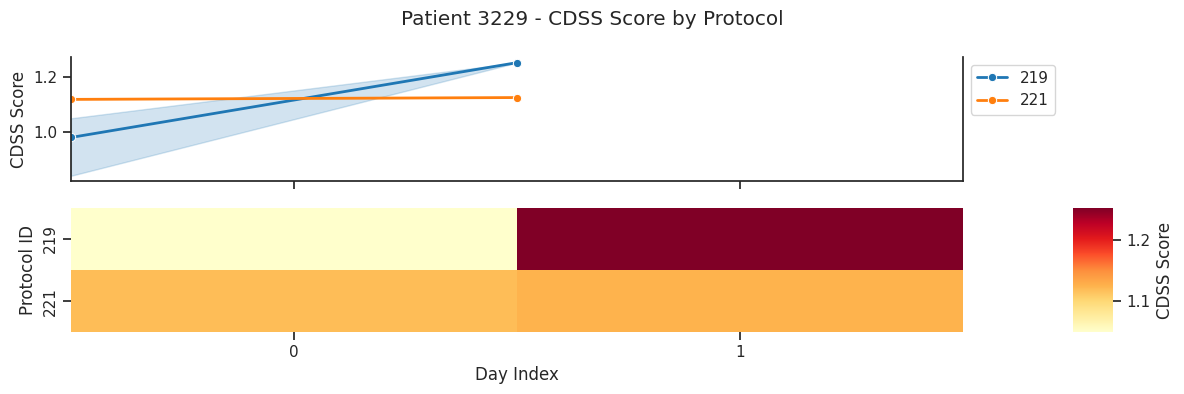

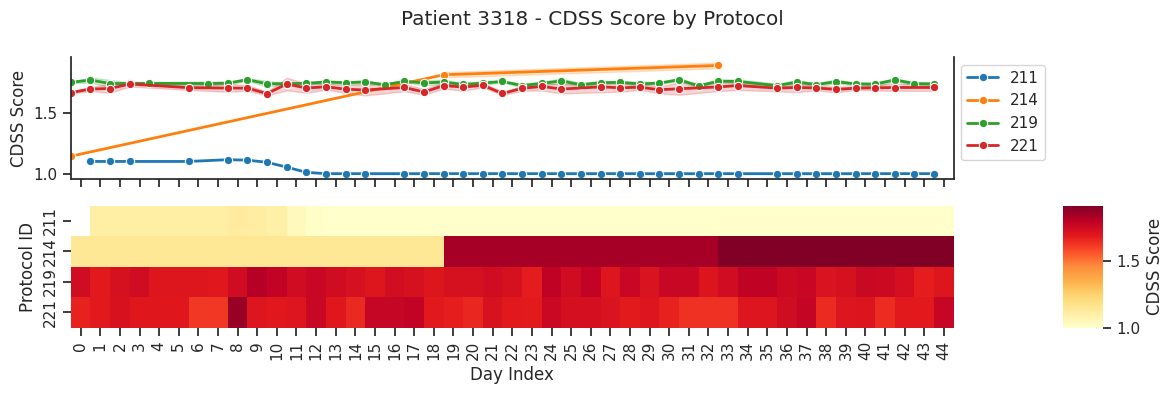

In [ ]:
output_dir = 'patient_reports'
for i, group in scores.groupby(by=PATIENT_ID):    
    plot_score(
        group,
        filename=os.path.join(output_dir, f"patient_{i}_protocols.png")
    )

just heatmap

In [438]:
import os

# Output directory
output_dir = 'patient_reports'
os.makedirs(output_dir, exist_ok=True)

# Collect image filenames
image_files = []

# Generate plots per patient
for i, group in scores.groupby(by=PATIENT_ID):
    filename = os.path.join(output_dir, f"patient_{i}_protocols.png")
    # plot_score(group, filename=filename)
    image_files.append(f"patient_{i}_protocols.png")  # just filename for HTML

# Generate HTML report
html_content = """
<html>
<head>
<style>
body {
    margin: 0;
    padding: 0;
}
table {
    table-layout: fixed;
    border-collapse: collapse;
    width: auto;
    white-space: nowrap;
}
td {
    text-align: center;
    vertical-align: top;
    padding: 0;
    border: none;
}
img {
    width: 300px;
    height: auto;
    display: block;
    margin: auto;
    border: 1px solid #ddd;
}
</style>
</head>
<body>
<table>
<tr>
"""

# Add each patient image in a table column
for image_file in image_files:
    html_content += f'<td><img src="{image_file}"></td>'

html_content += """
</tr>
</table>
</body>
</html>
"""

# Save HTML
html_file_path = os.path.join(output_dir, "summary.html")
with open(html_file_path, "w") as f:
    f.write(html_content)

print(f"✅ Report saved to {html_file_path}")


✅ Report saved to patient_reports/summary.html


altogether

In [445]:
import os
import pandas as pd

# --- Config ---
input_dir = "dms_nest_complete"
heatmap_dir = "patient_reports"  # <- your heatmaps directory!
output_html = os.path.join(input_dir, "nest_gallery.html")

# --- Collect Protocol-Patient Images ---
image_files = [f for f in os.listdir(input_dir) if f.endswith(".png")]

data = []
for filename in image_files:
    try:
        parts = filename.replace(".png", "").split("_")
        patient_id = int(parts[1])
        protocol_id = int(parts[3])
        data.append((protocol_id, patient_id, filename))
    except Exception as e:
        print(f"Skipping file {filename}: {e}")

df = pd.DataFrame(data, columns=["PROTOCOL_ID", "PATIENT_ID", "FILENAME"])

patients = sorted(df["PATIENT_ID"].unique())
protocols = sorted(df["PROTOCOL_ID"].unique())

# --- Collect Patient Heatmaps ---
heatmap_files = [f for f in os.listdir(heatmap_dir) if f.endswith(".png")]
heatmap_map = {}
for filename in heatmap_files:
    try:
        patient_id = int(filename.split("_")[1])
        heatmap_map[patient_id] = filename
    except Exception as e:
        print(f"Skipping heatmap {filename}: {e}")

# --- Start HTML ---
html_content = """
<html>
<head>
<style>
body {
    margin: 0;
    padding: 0;
    font-family: Arial, sans-serif;
}
table {
    table-layout: fixed;
    border-collapse: collapse;
    width: auto;
    white-space: nowrap;
    border: 1px solid #ccc;
}
td, th {
    border: 1px solid #ccc;
    padding: 5px;
    text-align: center;
}
img {
    width: 300px;
    height: auto;
    display: block;
    margin: auto;
    border: 1px solid #ddd;
}
th {
    background-color: #f9f9f9;
}
</style>
</head>
<body>
<h2>Protocol × Patient Gallery</h2>
<table>
<tr>
    <th>Protocol \\ Patient</th>
"""

# --- Header row (patients) ---
for patient_id in patients:
    html_content += f"<th>Patient {patient_id}</th>"
html_content += "</tr>\n"

# --- Protocol × Patient images ---
for protocol_id in protocols:
    html_content += f"<tr><th>Protocol {protocol_id}</th>"
    for patient_id in patients:
        match = df[(df["PROTOCOL_ID"] == protocol_id) & (df["PATIENT_ID"] == patient_id)]
        if not match.empty:
            filename = match["FILENAME"].values[0]
            html_content += f'<td><img src="{filename}"></td>'
        else:
            html_content += "<td></td>"  # Empty cell
    html_content += "</tr>\n"

# --- Add heatmaps row at the end ---
html_content += "<tr><th>Patient Heatmap</th>"
for patient_id in patients:
    heatmap_filename = heatmap_map.get(patient_id)
    if heatmap_filename:
        html_content += f'<td><img src="../{heatmap_dir}/{heatmap_filename}"></td>'
    else:
        html_content += "<td></td>"
html_content += "</tr>\n"

# --- Close HTML ---
html_content += """
</table>
</body>
</html>
"""

# --- Save ---
with open(output_html, "w") as f:
    f.write(html_content)

print(f"✅ Gallery HTML created with heatmaps: {output_html}")


✅ Gallery HTML created with heatmaps: dms_nest_complete/nest_gallery.html


Now I want to see daily PPF, and distribution of PPF
Also we want add initialized protocols
And display the logic, either top or swaps

`CumPPF per day` + `distribution of PPF`